## V3


Hello, I'm NASS-GPT! I'm here to help you grab whatever NASS Quickstats data you
may need and then help you analyze it! What information can I help grab for you?

Please type your question: Apples grown in 2021
This is for debugging purposes only: https://quickstats.nass.usda.gov/api/api_GET/?key=03D05FC5-8939-3C58-A75D-E99BF678E6F0&commodity_desc=APPLES&year__GE=2021
Data successfully pulled from NASS API with shape (20158, 39)
Now generating some cool potential analyses!
Here are three exploratory data analysis ideas for the given dataframe:

1. Visualize the distribution of organic apple acreage harvested for each state in 2021.


2. Calculate the average organic apple acreage harvested in 2021 for each prodn_practice_desc (production practice description).


3. Determine the state with the maximum organic apple acreage harvested in 2021.

Which analysis would you like to see?: 1


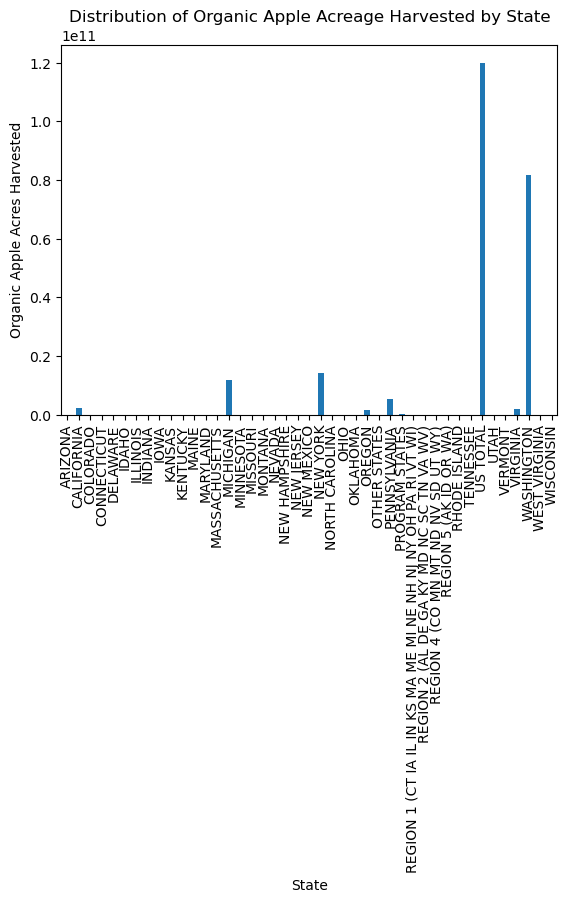


What else can I assist you with today?
Please type your question: quit

Thank you for using NASS-GPT. Have a wonderful day!

In [10]:
import os
import openai
import pandas as pd
import requests
import time
import re


'''
How this works:
There are 3 bots to handle user questions about the NASS quickstats API

Bot #1 : The Sorter
Bot #1's job is to decide if a question being asked by the user is a question 
having to do with the NASS Quickstats API


Bot #2: The API Maker
Bot #2's job is to create an API url that successfully pulls down the data from
NASS quickstats.

Bot #3: The Data Analyzer
Bot #3's job is to take an existing dataset and provide some analysis, mostly a graph or two
'''

#______________________Configuration items___________________________________

#Maximum number of times GPT will be asked to fix a broken API link
num_retries = 5

#API stuff
openai.api_key = open("/Users/jackogozaly/Desktop/Python_Directory/key.txt", "r").read().strip("\n")
quickstats_api_key = open("/Users/jackogozaly/Desktop/Python_Directory/nass_key.txt", "r").read().strip("\n")

#What to say to the user at various stages
intro_string = """
Hello, I'm NASS-GPT! I'm here to help you grab whatever NASS Quickstats data you
may need and then help you analyze it! What information can I help grab for you?
"""            
ongoing_string = "\nWhat else can I assist you with today?"
ending_string = "\nThank you for using NASS-GPT. Have a wonderful day!"


##___________________Bot 1 configuration______________________________##
sorter_bot_chat = [{"role": "user", "content": 
                    """
                    You are a large language model trained to classify questions into one of 2 buckets
                    the first bucket is 'API CALL'. Questions should be classified this way if they are asking a question that could be answered by the NASS quickstats API.
                    The second bucket is called "Analysis". Question should be classified this way if they are asking a question about how to analyze an existing dataframe. or other general analysis questions.
                        
                    You can only respond with the name of one of these buckets, give no other info. Besides "API CALL" or "Analysis". Got it? If you are very confused, you can ask the user for clarification.                 
                    """},
                   {"role": "assistant", "content": "OK"}]


##___________________Bot 2 configuration______________________________##
api_bot_chat = [{"role": "user", "content": 
                    """
                    You are a large language model trained to convert questions about agricultural data into NASS Quickstats API links. 
                    When answering a question only provide the URL link and skip any other ouputs unless it is a task you cannot do. Do not provide any instructions other than an API link.
                    If you can complete the task, respond with 'SUCCESS' followed immediately by the API link. Include no additional text explaining the API link for saying 'here it is'
                    When creating the URL, follow this API key format key=YOUR_API_KEY
                    
                    """},
                   {"role": "assistant", "content": "OK"}]



##___________________Bot 3 configuration______________________________##

python_bot_chat = [{"role": "user", "content": 
                    """
                    You are a large language model trained to convert questions about NASS Quickstats data into exploratory data anlysis via python code.
                    If you understand the question being asked of you respond with 'SUCCESS' and then paste whatever python code you have. Do not add any other language to the output.
                    If you do not understand the question being asked of you, respond however you want for clarification.
                    """},
                   {"role": "assistant", "content": "OK"}]

                    
       ##___________________Bot 4 configuration______________________________##             
eda_bot_chat = [{"role": "user", "content": 
                    """
                    You are a large language model trained to take in the first 5 rows of data frome a dataframe along with some context and come up with the best 3
                    exploratory data analysis ideas. The ideas should be fairly simple and able to be done in a couple lines of python code. examples include making a matplotlib graph, group by statements, etc.
                    
                    Only output 3 and only 3 ideas, and below each idea place the python code for how to do it. 
                    
                    The user's next input will be to select one of those ideas, and which idea they choose, output that python code and only that python code, no other text for the second response. When developing python code, refer to column names
                    do not create lists of data'
                    
                    """},
                   {"role": "assistant", "content": "OK"}]

                    
                    
                    


def fake_typing(string_):
    for char in string_:
        print(char, end='')
        time.sleep(.01)


def predict(model_type_chat, user_input):
    '''
    Takes a user's input and attemtps to generate a response
    '''
    model_type_chat.append({"role": "user", "content": f"{user_input}"})
    
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=model_type_chat)
    
    reply_txt = response.choices[0].message.content
    
    model_type_chat.append({"role": "assistant", "content": f"{reply_txt}"})
    return reply_txt


def api_read(response):
    
    api_link = response.split()
    api_link = [link for link in api_link if link.startswith('https')]
    if not api_link:
        api_error_message = "No link made"
        return(api_error_message)

    else:
        api_link = api_link[0]
        api_link = api_link.replace("YOUR_API_KEY", quickstats_api_key)
        print(f"This is for debugging purposes only: {api_link}")
            
        # Make the API request
        api_pull = requests.get(api_link)
        data = api_pull.json()

        
        if "error" not in data:
            # Extract the relevant data from the response
            relevant_data = data.get('data', [])
            # Create a DataFrame
            df = pd.DataFrame(relevant_data)
            return(df)
        
        elif data['error'] == ['exceeds limit=50000']:

            api_error_message = "Too much data requested"
            print("""⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣤⣤⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣶⣿⠟⠉⠉⠻⣿⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣤⣾⠿⠉⠀⠀⠀⠀⠀⠹⣿⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣴⣾
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⣿⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣴⣾⡿⠛⠉
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⣿⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⣾⡿⠟⠁⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣴⣿⡿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣷⣶⣶⣦⣤⣤⣄⡀⠀⢀⣠⣾⣿⠿⠋⠀⠀⠀⠀⠀⣠
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⣿⣿⡿⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣤⠶⠞⣿⠟⠋⠉⠉⠙⣻⠿⢿⣿⣿⣿⠟⠁⠀⠀⠀⠀⠀⢀⡼⠁
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⣿⠁⠛⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⠟⠁⢠⡞⠁⠀⠀⠀⢀⡴⠋⠀⢀⡿⠋⠁⠀⠀⠀⠀⠀⠀⠀⡞⠁⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣼⣿⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⠃⠀⢠⠏⠀⠀⠀⠀⣰⠏⠀⠀⣠⠟⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡥⠤⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⣿⠟⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⣇⠀⣠⡏⠀⠀⠀⠀⣼⠁⠀⠀⣰⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡴⠁
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣄⣄⣼⣿⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⡶⠋⠀⠀⠀⠀⢸⣧⠀⠀⣴⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢧⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⠀⠀⠀⠀⣾⡿⠿⣿⡿⠁⠀⠀⠀⠀⠀⠀⣠⣶⣶⣶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠛⠛⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳
⠀⠀⠀⠀⠀⠀⢀⣾⠿⠛⢿⣿⣷⣄⡀⣿⠃⠀⠈⠀⠀⠀⠀⠀⠀⢀⣾⣿⣿⣿⣿⣧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⣠⣤⣦⣼⣿⠀⠀⠀⣿⣿⣿⣿⣿⣦⣀⠀⠀⠀⠀⠀⠀⠀⣿⣿⣿⣿⣿⣿⡿⠀⠀⠀⢀⣀⣀⣀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣤⣾⣿⣿⣿⣷⣄⠀⠀⠀⠀⠀⠀⠀
⠀⣠⣾⡿⠋⠉⠉⠁⠀⠀⠀⠀⠉⢯⡙⠻⣿⣿⣷⣤⡀⠀⠀⠀⠀⢿⣿⣿⣿⣿⡿⠃⢀⡤⠖⠋⠉⠉⠉⠉⠉⠉⠒⠦⣄⠀⠀⠀⠀⠀⣾⣿⣿⣿⣿⣿⣿⣿⣧⠀⠀⠀⠀⠀⠀
⣾⣿⠋⠀⠀⠀⠀⣀⣀⠀⠀⠀⠀⠀⠙⢦⣄⠉⠻⢿⣿⣷⣦⡀⠀⠈⠙⠛⠛⠋⠀⢰⠟⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⠀⠀⠀⠀⠀
⣿⡇⠀⠀⠀⣴⠟⣫⣿⣿⣄⠀⠀⠀⠀⡶⢌⡙⠶⣤⡈⠛⠿⣿⣷⣦⣀⠀⠀⠀⠀⡇⠀⢻⣄⠀⠀⣠⢷⠀⠀⠀⠀⠀⡶⠀⠘⡆⠀⠀⠻⣿⣿⣿⣿⣿⣿⣿⡟⠀⠀⠀⠀⠀⠀
⣿⡇⠀⠀⢸⣟⢸⣿⣿⣿⣿⠀⠀⠀⠀⡇⠀⠈⠛⠦⣝⡳⢤⣈⠛⠻⣿⣷⣦⣀⠀⠀⠀⠀⠈⠙⠋⠁⠀⠛⠦⠤⠤⠚⠁⠀⠀⢳⠀⠀⠀⠈⠛⠿⠿⠿⠟⠋⠀⠀⠀⠀⠀⠀⠀
⣿⡇⠀⠀⠈⢿⣞⣿⣿⣿⠏⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠙⠳⢬⣛⠦⠀⠙⢻⣿⣷⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⡇⠀⠀⠀⠀⠉⠛⠋⠁⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠈⠁⠀⠀⠈⣿⠉⢻⣿⣷⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡼⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⡇⠀⠀⠀⠀⠀⣠⣄⠀⠀⢰⠶⠒⠒⢧⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⢸⡇⢸⡟⢿⣷⣦⣴⣶⣶⣶⣶⣤⣔⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⡇⠀⠀⣤⠀⠀⠿⠿⠁⢀⡿⠀⠀⠀⡄⠈⠙⡷⢦⣄⡀⠀⠀⠀⠀⠀⠀⠀⣿⠀⢸⡇⢸⡇⠀⣿⠙⣿⣿⣉⠉⠙⠿⣿⣧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⡇⠀⠀⠙⠷⢤⣀⣠⠴⠛⠁⠀⠀⠀⠇⠀⠀⡇⢸⡏⢹⡷⢦⣄⡀⠀⠀⠀⣿⡀⢸⡇⢸⡇⠀⡟⠀⢸⠀⢹⡷⢦⣄⣘⣿⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⣿⣿⠢⣤⡀⠀⠀⠀⠀⠀⠀⣠⠾⣿⣿⡷⣤⣀⡇⠸⡇⢸⡇⢸⠉⠙⠳⢦⣄⡻⢿⣾⣧⣸⣧⠀⡇⠀⢸⠀⢸⡇⢤⣈⠙⠻⣿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢹⣿⣷⣌⡉⠛⠲⢶⣶⠖⠛⠛⢶⣄⡉⠛⠿⣽⣿⣶⣧⣸⡇⢸⠀⠀⠀⠀⠈⠙⠲⢮⣝⠻⣿⣷⣷⣄⣸⠀⢸⡇⠀⠈⠁⠀⢸⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠙⠻⢿⣷⣶⣤⣉⡻⢶⣄⣀⠈⠙⠳⢦⣈⡉⠻⢿⣿⣷⣾⣦⡀⠀⠀⠀⠀⠀⠀⠈⠙⠲⢭⣛⠿⣿⣷⣼⡇⠀⠀⠀⠀⠈⣿⡇⠀⠀⠀⠀⠀⠀⣀⠀⠀⠀⠀⠀⠀⠀⠀⣀
⠀⠀⠀⠀⠀⠈⠙⠻⢿⣿⣷⣶⣽⣻⡦⠀⠀⠈⠙⠷⣦⣌⡙⠻⢿⣟⣷⣤⣀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠳⢯⣻⡇⠀⠀⠀⠀⠀⢸⣿⠀⣀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⢀⡏⠙⠛
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⠻⢿⣿⣿⣿⣶⣤⣤⣤⣀⣈⠛⠷⣤⣈⡛⠷⢽⡻⢶⣄⣀⠀⠀⠀⠀⠀⠀⠀⠈⠛⠳⢤⣀⠀⠀⢸⣿⡀⠈⠳⢤⣀⣀⣰⠃⠈⠛⠶⠶⠿⠃⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢈⣿⡿⠛⠉⠙⠛⠛⠻⢷⣦⣄⣩⣿⠶⠖⠛⠛⠛⠛⠛⠛⠿⢷⣶⣦⣄⠀⠀⠀⠀⠉⢻⣶⣿⣿⠇⠀⠀⠀⠉⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⣿⠁⠀⠀⠀⠀⠀⠀⠀⣿⣿⠋⠀⠀⠀⠀⠀⣠⠖⠂⠀⠀⠀⠈⠙⠿⣿⣦⡄⠀⠀⣸⣿⠟⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⣿⡟⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⣰⠊⠁⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⣶⣄⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠇⠀⠀⠀⠀⠀⠀⠀⠀⢸⣧⠀⠀⢀⠞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡠⠙⢿⣿⣇⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡿⠿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⡿⠦⠠⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠧⠤⠄⠙⡿⠿⠦⠤⠤⠤⠤⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

Wow, that was a big request... You have 10 seconds to change your request to something smaller

      """)
            
            return(api_error_message)
        
        
        elif data['error'] == ['bad request - invalid query']:
            
            api_error_message = "Broken API url"
            
            return(api_error_message)
        
        else:
            return("Some other error")



i = 0 

while True:    

    #Same text guiding the user as to what they need to do
    if i == 0:
        fake_typing(intro_string)
    else:
        fake_typing(ongoing_string)
    
    #This input is going to be used to determine which GPT model gets used
    user_in = input("\nPlease type your question: ")
    #Ability to break loop
    if user_in.lower() == "quit":
        #Say goodbye and end while loop
        fake_typing(ending_string)
        break
    
    sorter_val = predict(model_type_chat = sorter_bot_chat, user_input = user_in)
    
    
    
    
    num_tries = 0
    
    if sorter_val == 'API CALL':
        while sorter_val == 'API CALL' and (num_tries < num_retries):
            
            api_link_ = predict(model_type_chat = api_bot_chat, user_input = user_in)
            
            #Take the chatGPT 
            api_data = api_read(api_link_)
            
            #If it goes down the if clause, we were able to pull the data successfully
            if isinstance(api_data, pd.DataFrame) and len(api_data) > 0:
                #The Value column in the dataframe comes in as a string with weird formatting
                #Quirks
                if 'Value' in api_data.columns:
                    api_data['Value'] = api_data['Value'].str.replace(',', '', regex=False)
                    api_data['Value'] = api_data['Value'].str.replace('(NA)', '', regex=False)
                    api_data['Value'] = api_data['Value'].str.replace('()', '', regex=False)
                    api_data['Value'] = pd.to_numeric(api_data['Value'], errors= "coerce")
                
                print(f"Data successfully pulled from NASS API with shape {api_data.shape}")

                fake_typing("Now generating some cool potential analyses!\n")
                
                
                df_head = api_data.head().to_json(orient='records')[1:-1].replace('},{', '} {')
                
                eda_output = predict(model_type_chat = eda_bot_chat, user_input = f"what kind of analysis could I do on a dataframe from USDA NASS that {user_in}. The data looks like like: {df_head}")
                ideas = re.sub("```python.*?\n```", '', eda_output, flags=re.DOTALL)
                fake_typing(ideas)
                
                
                
                
                user_in = input("\nWhich analysis would you like to see?: ")
                #Ability to break loop
                if user_in.lower() == "quit":
                    #Say goodbye and end while loop
                    fake_typing(ending_string)
                    break
                
                eda_output = predict(model_type_chat = eda_bot_chat, user_input = f"{user_in}")
                
                df = api_data.copy()
                exec(eda_output.split('```python')[1].split('```')[0])
                
                sorter_val = 'Analysis'
                break
                
            
            else:
                
                num_tries += 1
                
                if isinstance(api_data, pd.DataFrame) and api_data.empty:
                    api_bot_chat.append({"role": "user", "content": "Please try again, I got an error using that link"})
                
                elif api_data == 'No link made':
                    api_bot_chat.append({"role": "user", "content": "Please try again to create an API url that will result in a dataframe"})
                
                elif api_data == 'Broken API url':
                    api_bot_chat.append({"role": "user", "content": "Please try again, I got an error using that link"})
                
                elif api_data == 'Too much data requested':
                    sorter_val = ''
                
                else:
                    api_bot_chat.append({"role": "user", "content": "Please try again, I got some unknown error using that link"})
                
        if num_tries >= num_retries:
            fake_typing("I'm sorry, but I'm unable to get that data. Can you try again?")
            
            
            


    elif sorter_val == 'Analysis':
        print("sorted as analysis")
    
    else:
        print(sorter_val)

    #Ability to break loop
    if user_in.lower() == "quit":
        #Say goodbye and end while loop
        fake_typing(ending_string)
        break


    

    #Add to our counter so we can change pre-determined text
    i += 1
    